# Capstone project: Heartbeat Sounds Classification
Classifying heartbeat anomalies from stethoscope audio
**Kaggle: Challenge 2**

# Problem Statement:
Stethoscope is good in detecting the first warning signs of heart disease. However, this is always done by frontline health workers, mostly when we are sick or during our annual physical examination. Although digital stethoscopes is available but we still need healthcare professional to determine whether an individual is having hearbeat irregularities or abnormalities and need for further check-up. 
It is well known that early detection and intervention in heart disease (or any disease) will greatly imporves the lifespan and the effectiveness of treatment options. 

The **goal** of this project is to use machine learning methods to identify and **classify heartbeat sounds** from audio collected from stethoscopes into normal versus various non-normal heartbeat sounds.


### Target Audience:
1. Untrained frontline health workers to help determine whether an individual should bre reffered to expert diagnosis.
2. Consumer who can frequently check their respiratory health or constantly monitor if there is an heartbeat irregularities that prompt them to seek treatment in early stage. 

### Success Metric
Model selections: Supervised Classification: CNN (convolutional neural network), RNN (recurrent neural network) 

Evaluation metric: Accuracy, Precision, Youden's Index, F1-score

### Data Source
[kaggle dataset: Heartbeat Sounds](https://www.kaggle.com/kinguistics/heartbeat-sounds)

### Potential Challenge
1. No experience in handling of unstructure audio data and its extra step for pre-processing, features extraction
2. Not the domain expert in respiratory health

## Importing Libraries

In [124]:
import pandas as pd
import numpy as np
#import scipy
from scipy.signal import welch

## audio
import librosa as lr
from librosa import display
import wave                    # library handles the parsing of WAV file headers
import pywt
import IPython.display as ipd  #audio playback

## plot
import matplotlib.pyplot as plt
import seaborn as sns

## others
from glob import glob
import itertools
import os
from IPython.display import Image

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight

## keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

#To visualize the whole grid
pd.options.display.max_columns = 999

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['rec', 'shuffle', 'display']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Task 2: Heart Sound Segmentation

The task is to produce a method that can **classify the unlabeled real heart audio** (also known as “beat classification”) into the correct categories after training on both dataset A and dataset B.

|Dataset|Number of Categories|Categories|Sources|Recorded by|
|---|---|---|---|---|
|A|4|Normal, Murmur, Extra Heart Sound, Artifact|general public|iStethoscope Pro iPhone app|
|B|3|Normal, Murmur, Extrsystole|clinic trial in hospitals|digital stethoscope|

- audio files - Varying lengths, between 1 second and 30 seconds. (some have been clipped to reduce excessive noise and provide the salient fragment of the sound).

source: [Peter Bentley et al](http://www.peterjbentley.com/heartchallenge/)

# 1 Data Cleaning and Exploratory Data Analysis (EDA)

## List all datasets downloaded for Task 2
- two sets of wav files (set_a, set_b)
- three csv files (set_a, set_b, and set_a_timing)

In [2]:
ls ../datasets/challenge2/

set_a/            set_a_timing.csv* set_b.csv*
set_a.csv*        set_b/


In [3]:
ls ../datasets/challenge2/set_a/

Aunlabelledtest__201012172010.wav* artifact__201106211430.wav*
Aunlabelledtest__201101051105.wav* artifact__201106212112.wav*
Aunlabelledtest__201101061552.wav* artifact__201106220340.wav*
Aunlabelledtest__201101091156.wav* artifact__201106221254.wav*
Aunlabelledtest__201101110659.wav* extrahls__201101070953.wav*
Aunlabelledtest__201101152256.wav* extrahls__201101091153.wav*
Aunlabelledtest__201101220549.wav* extrahls__201101152255.wav*
Aunlabelledtest__201101241434.wav* extrahls__201101160804.wav*
Aunlabelledtest__201102081033.wav* extrahls__201101160808.wav*
Aunlabelledtest__201102081045.wav* extrahls__201101161027.wav*
Aunlabelledtest__201102200848.wav* extrahls__201101241423.wav*
Aunlabelledtest__201103011036.wav* extrahls__201101241433.wav*
Aunlabelledtest__201103140236.wav* extrahls__201102070251.wav*
Aunlabelledtest__201103170122.wav* extrahls__201102071835.wav*
Aunlabelledtest__201103200518.wav* extrahls__201102241217.wav*
Aunlabelledtest__201103201314.wav* extrahls__2011031501

## 1.1 EDA : csv file

Explore the information provided by the 3 csv files

In [2]:
## load and explore set_a
set_a = pd.read_csv('../datasets/challenge2/set_a.csv')
set_a.head()

dataset                             fname     label  sublabel
0       a  set_a/artifact__201012172012.wav  artifact       NaN
1       a  set_a/artifact__201105040918.wav  artifact       NaN
2       a  set_a/artifact__201105041959.wav  artifact       NaN
3       a  set_a/artifact__201105051017.wav  artifact       NaN
4       a  set_a/artifact__201105060108.wav  artifact       NaN

In [5]:
### 4 columns in set a, with all null value in 'sublabel' column
set_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   dataset   176 non-null    object 
 1   fname     176 non-null    object 
 2   label     124 non-null    object 
 3   sublabel  0 non-null      float64
dtypes: float64(1), object(3)
memory usage: 5.6+ KB


In [6]:
### there are 52 null value in 'label' column, 
### those are the unlabeled wav file need to use machine learning model to correctly classify their category
set_a.isnull().sum()

dataset       0
fname         0
label        52
sublabel    176
dtype: int64

In [7]:
### There are 4 categories in set_a: artifact, extrahls, murmur, and normal heartbeat
set_a['label'].unique()

array(['artifact', 'extrahls', 'murmur', 'normal', nan], dtype=object)

In [3]:
## load and explore set_b
set_b = pd.read_csv('../datasets/challenge2/set_b.csv')
set_b.head()

dataset                                              fname       label  \
0       b  set_b/Btraining_extrastole_127_1306764300147_C...  extrastole   
1       b  set_b/Btraining_extrastole_128_1306344005749_A...  extrastole   
2       b  set_b/Btraining_extrastole_130_1306347376079_D...  extrastole   
3       b  set_b/Btraining_extrastole_134_1306428161797_C...  extrastole   
4       b  set_b/Btraining_extrastole_138_1306762146980_B...  extrastole   

  sublabel  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN

In [9]:
### Similarly, 4 columns in set a, there are some info in 'sublabel' column (not all null in set_a)
set_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 656 entries, 0 to 655
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   dataset   656 non-null    object
 1   fname     656 non-null    object
 2   label     461 non-null    object
 3   sublabel  149 non-null    object
dtypes: object(4)
memory usage: 20.6+ KB


In [10]:
### there are 195 null value in 'label' column, 
### those are the unlabeled wav file need to use machine learning model to correctly classify their category

set_b.isnull().sum()

dataset       0
fname         0
label       195
sublabel    507
dtype: int64

In [4]:
### There are 3 categories in set_a: extrastole, murmur, and normal heartbeat
set_b['label'].unique()

array(['extrastole', 'murmur', 'normal', nan], dtype=object)

**`sublabel`** column

This column label those wav with extra amount of background noise.

source: [Peter Bentley et al](http://www.peterjbentley.com/heartchallenge/)

Dataset B contains noisy_normal data - normal data which includes a substantial amount of background noise or distortion. You may choose to use this or ignore it. However the test set will include some equally noisy examples.

In [12]:
### some of the wav file from 'murmur' or 'normal' categories have extra background noise
set_b['sublabel'].unique()

array([nan, 'noisymurmur', 'noisynormal'], dtype=object)

In [13]:
### load and explore set_a_timing
### this csv file contains 21 wav file with their S1 & S2 location in the wavv.
timing = pd.read_csv('../datasets/challenge2/set_a_timing.csv')

print(f' number of unique fname: {timing.fname.nunique()}')
timing.head()

 number of unique fname: 21


fname  cycle sound  location
0  set_a/normal__201102081321.wav      1    S1     10021
1  set_a/normal__201102081321.wav      1    S2     20759
2  set_a/normal__201102081321.wav      2    S1     35075
3  set_a/normal__201102081321.wav      2    S2     47244
4  set_a/normal__201102081321.wav      3    S1     62992

In [14]:
### no null avlue in this csv file
timing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390 entries, 0 to 389
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   fname     390 non-null    object
 1   cycle     390 non-null    int64 
 2   sound     390 non-null    object
 3   location  390 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 12.3+ KB


### Combine set_a & set_b csv files

There are total of 832 wav files, with **585** labeled (training set), and **247** unlabeled (test set).

**351** out of 585 labeled wav files are from `normal` category.

In [5]:
set_ab = pd.concat([set_a, set_b])
set_ab.describe()

dataset                           fname   label     sublabel
count      832                             832     585          149
unique       2                             832       5            2
top          b  set_a/murmur__201108222255.wav  normal  noisynormal
freq       656                               1     351          120

In [16]:
set_ab.isnull().sum()

dataset       0
fname         0
label       247
sublabel    683
dtype: int64

### Distribution of the heartbeat sound files per category

- `normal` heartbeat category is the majority class, with 351 out of total 585 (60%)
- `extrahls` heartbeat category is the minority class, with only 19 (3.2%)

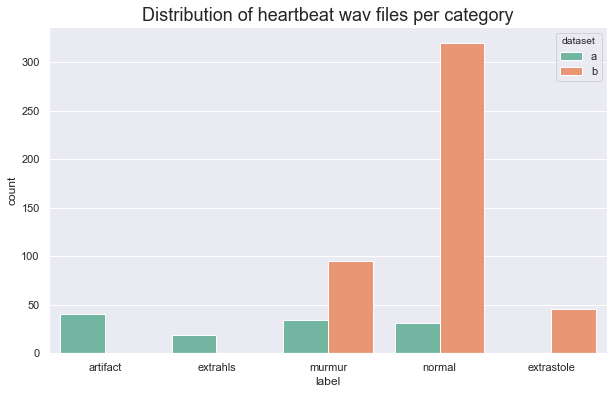

In [17]:
sns.set(style="darkgrid")
plt.figure(figsize = (10,6))
ax = sns.countplot(x='label', hue = 'dataset', data = set_ab, palette="Set2");
ax.set_title('Distribution of heartbeat wav files per category', fontsize = 18);

In [18]:
### Get the count number per category
set_ab.groupby('label').count()

dataset  fname  sublabel
label                               
artifact         40     40         0
extrahls         19     19         0
extrastole       46     46         0
murmur          129    129        29
normal          351    351       120

In [19]:
### Percentage per category
set_ab.groupby('label')['dataset'].count()/585*100

label
artifact       6.837607
extrahls       3.247863
extrastole     7.863248
murmur        22.051282
normal        60.000000
Name: dataset, dtype: float64

## 1.2 EDA - Audio files


### Compile list of audio wav files in Atraining & Btraining folders

use `glob()` to return a list of audio wav files that match the wav files' name in folder that store them.

In [6]:
### set_a folder
wav_dir_set_a = '../datasets/challenge2/set_a/'
a_wav = glob(wav_dir_set_a + '/*.wav')
print(f'Total wav file in set_a folder :{len(a_wav)}')

Total wav file in set_a folder :176


In [7]:
### set_b folder:
wav_dir_set_b = '../datasets/challenge2/set_b/'
b_wav = glob(wav_dir_set_b + '/*.wav')
print(f'Total wav file in set_b folder :{len(b_wav)}')

Total wav file in set_b folder :656


### Getting basic information on the audio wav files

In both set_a and set_b folders, they consist of heartbeat sounds from different categories and stored as **WAV** files.

In general, uncompressed audio is stored as a sequence of numbers that indicate the amplitude of the recorded sound pressure at each time point. In the WAV standard, these numbers are packed into a bytestring. The interpretation of this bytestring depends primarily on two factors: 
1. Sampling rate (framerate), usually given in Hertz, which indicates how many number samples comprise in one second's worth of data. 
2. Bit depth (sample width), number of bytes per sample.

On top of the two listed above, WAV file parameters include number of channels. Typically, they have 1 (mono) or 2 (for stereo). The data of a WAV file is given as a sequence of frames. A frame consists of samples. There is one sample per channel, per frame. Every wav file has a sample width, or, the number of bytes per sample. Typically this is either 1 or 2 bytes.

The `wave` library handles the parsing of WAV file headers, which include the parameters mentioned above. 

**set_a**
- mono channel
- sample width = 2 bytes (16 bits per sample)
- sampling rate = 44.1kHz

**set_b**
- mono channel
- sample width = 2 bytes (16 bits per sample)
- sampling rate = 4kHz

In [22]:
### set_a
f = wave.open(a_wav[0])
f.getparams()

_wave_params(nchannels=1, sampwidth=2, framerate=44100, nframes=349958, comptype='NONE', compname='not compressed')

In [23]:
### set_b
f = wave.open(b_wav[0])
f.getparams()

_wave_params(nchannels=1, sampwidth=2, framerate=4000, nframes=16188, comptype='NONE', compname='not compressed')

### 1.2.1 Defining plot function for visualization of audio wav file in time and frequency domain

**LibROSA** is used in this EDA. Librosa is a python package for music and audio analysis. It provides the building blocks necessary to create music information retrieval systems.

`librosa.load()` function returns 2 things:
- numpy array of amplitudes
- sampling rate (if keep the argument `sr = None`, it will load the audio file in its original sampling rate, else it will use its default sampling rate of `22050`)


In [8]:
### Define function to plot the audio in time domain
### This function return: 1) audio_data in array, 2) sampling rate, 
### 3) duration of audio wav, 4) plot the audio data in time domain

def time_plot(audio):
    
    #Load audio with librosa
    data, sfreq = lr.load(audio)
    
    plt.figure(figsize = (14,6))
    lr.display.waveplot(data, sr = sfreq);
    
    plt.xlabel('Time, s', fontsize=14)
    plt.ylabel('Amplitude', fontsize =14)
    plt.title(audio[29:], fontsize =18)
    
    audio_data = data
    sampling_frequency = sfreq
    dur = lr.get_duration(data)
    return audio_data, sampling_frequency, dur

In [9]:
### Define function to plot the audio in frequency domain

def fft_plot(audio):
    
    #Load audio with librosa
    data, sfreq = lr.load(audio)
    
    #check if the len of audio data is odd number
    n = len(data)
    if n%2 !=0:
        n = n+1   # if size of audio data is in odd number, add one to it before proceed
   
    t = 1/sfreq
    yf = scipy.fft(data)
    xf = np.linspace(0.0, 1.0/(2.0*t), n//2)    #frequency
    
    fig, ax = plt.subplots(figsize = (8,6))
    ax.plot(xf, 2.0/n * np.abs(yf[:n//2]))
    plt.grid()
    plt.xlabel('Frequency, Hz', fontsize = 14)
    plt.ylabel('Amplitude', fontsize =14)
    plt.title(audio[29:], fontsize =18)
    plt.grid()

    ax.set_xscale('log')    #set frequency axis in log scale
    ax.set_xlim(1, 1000)
    ax.set_ylim(0, 0.05)
    
    
    return plt.show()
    

In [10]:
### Define function to plot the PSD (Power Spectra Density)
def psd_plot(audio):
    
    #Load audio with librosa
    data, sfreq = lr.load(audio)
    freq, psd = welch(data, fs = sfreq)
    
    fig, ax = plt.subplots(figsize = (8, 6))
    ax.plot(freq, psd, linestyle = '-', color = 'blue')
    
    ax.set_xlabel('Frequency, Hz', fontsize =14)
    ax.set_ylabel('PSD [V**2 / Hz', fontsize =14)
    ax.set_title(audio[29:], fontsize =18)
    
    ax.set_xlim(0, 1000)


### Heartbeat audio for all categories at a glance

- First column are heartbeat sound form set_a
- Second column are heartbeat sound from set_b

From a visual inspection it is not easy to visualize the difference between some of the categories of heartbeat sound, particularly those with more background noise (set_b). 

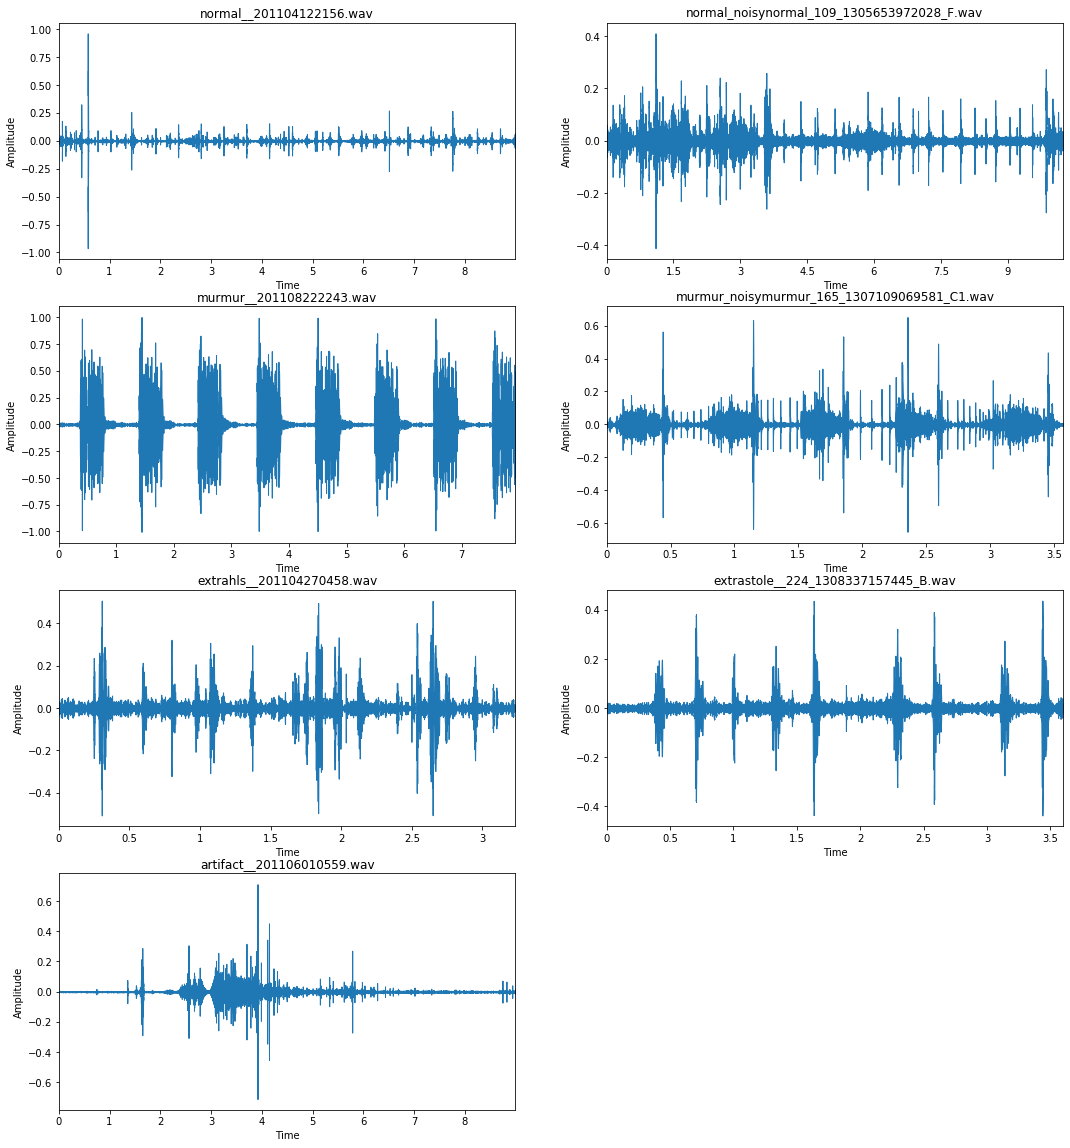

In [9]:
### Visualize all categories of heartbeat sound provided

select = [a_wav[14], b_wav[3], a_wav[11], b_wav[29], a_wav[18], b_wav[54], a_wav[10]]

fig = plt.subplots(figsize = (18,20))

for i in range(1,8):
    subplot(4,2,i)
    data, sr = lr.load(select[i-1])
    lr.display.waveplot(data, sr)
    
    plt.ylabel('Amplitude', fontsize =10)
    plt.title(select[i-1][29:], fontsize =12)


### 1.2.2 EDA on normal heartbeat audio

**Normal Category of heartbeat**
In the Normal category there are normal, healthy heart sounds. These may contain noise in the final second of the recording as the device is removed from the body. They may contain a variety of background noises (from traffic to radios). They may also contain occasional random noise corresponding to breathing, or brushing the microphone against clothing or skin. A normal heart sound has a clear “lub dub, lub dub” pattern, with the time from “lub” to “dub” shorter than the time from “dub” to the next “lub” (when the heart rate is less than 140 beats per minute). Note the temporal description of “lub” and “dub” locations over time in the following illustration:

…lub……….dub……………. lub……….dub……………. lub……….dub……………. lub……….dub…

In medicine we call the **lub** sound "**S1**" and the **dub** sound "**S2**". Most normal heart rates at rest will be between about 60 and 100 beats (‘lub dub’s) per minute. However, note that since the data may have been collected from children or adults in calm or excited states, the heart rates in the data may vary from 40 to 140 beats or higher per minute. Dataset B also contains noisy_normal data - normal data which includes a substantial amount of background noise or distortion. 

Duration of audio wav file: 7.94 sec


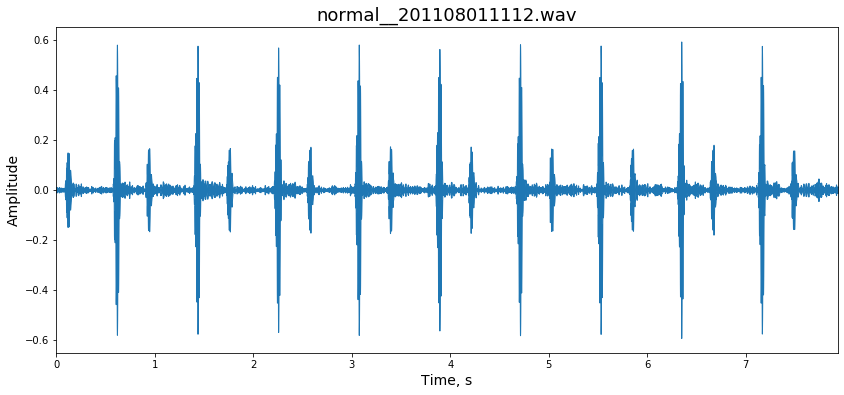

In [14]:
### Plot audio from a_wav[0]
data, sfreq, dur = time_plot(a_wav[0])

print(f'Duration of audio wav file: {round(dur, 2)} sec')

In [13]:
### Listen to the audio from a_wav[0]

ipd.Audio(a_wav[0])

Visual inpection on the audio in frequency domain (Frequency Spectrum)

The frequency spectrum shown in below graph observed that:
- the heart beat sound is at around 60Hz.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.
  


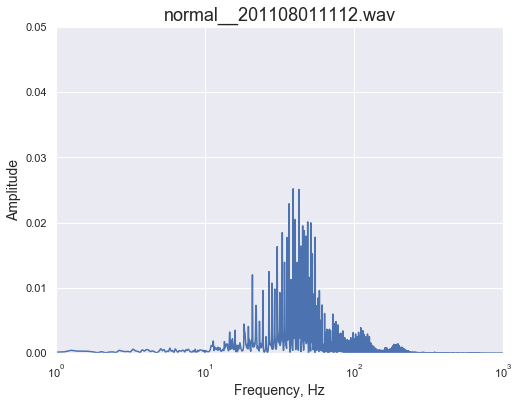

In [30]:
fft_plot(a_wav[0])

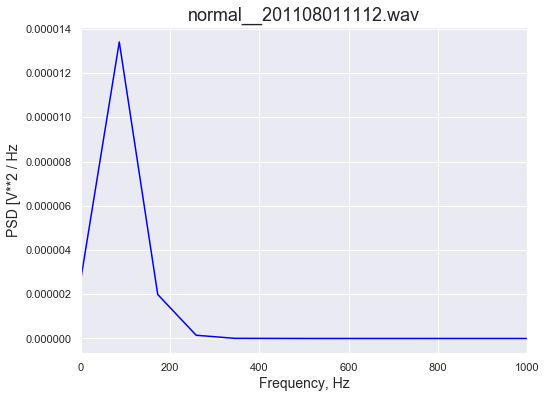

In [31]:
psd_plot(a_wav[0])

### 1.2.3 EDA on murmur heartbeat audio

Heart murmurs sound as though there is a “whooshing, roaring, rumbling, or turbulent fluid” noise in one of two temporal locations: (1) between “lub” and “dub”, or (2) between “dub” and “lub”. They can be a symptom of many heart disorders, some serious. There will still be a “lub” and a “dub”. One of the things that confuses non-medically trained people is that murmurs happen between lub and dub or between dub and lub; not on lub and not on dub. Below, you can find `''''` at the locations a murmur may be.

…lub..`''''`...dub……………. lub..`''''`..dub ……………. lub..`''''`..dub ……………. lub..`''''`..dub …

or

…lub……….dub…`''''''`….lub………. dub…`''''''`….lub ………. dub…`''''''`….lub ……….dub…

Dataset B also contains noisy_murmur data - murmur data which includes a substantial amount of background noise or distortion.

Duration of audio wav file: 7.94 sec


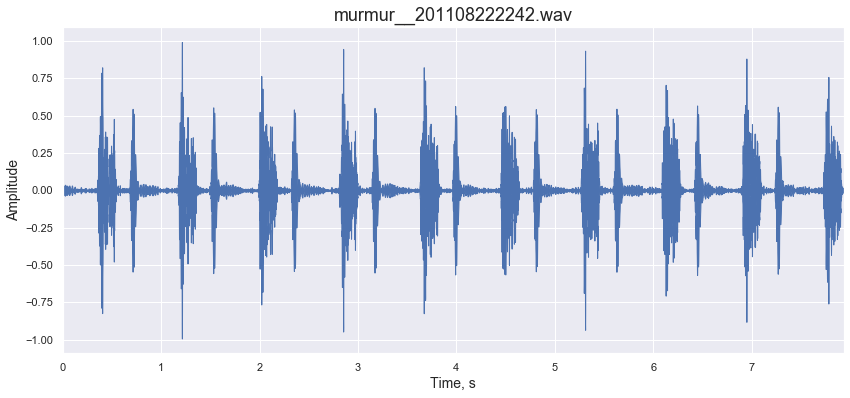

In [32]:
### Plot audio from a_wav[9]
data, sfreq, dur = time_plot(a_wav[9])

print(f'Duration of audio wav file: {round(dur, 2)} sec')

In [15]:
ipd.Audio(a_wav[9])

Visual inpection on the audio in both frequency domain and time domain:
- the heart beat sound is at around 60Hz.
- murmurs heard after S1 (lub), and at around 300Hz, the smaller peak in the fft plot shown below.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.
  


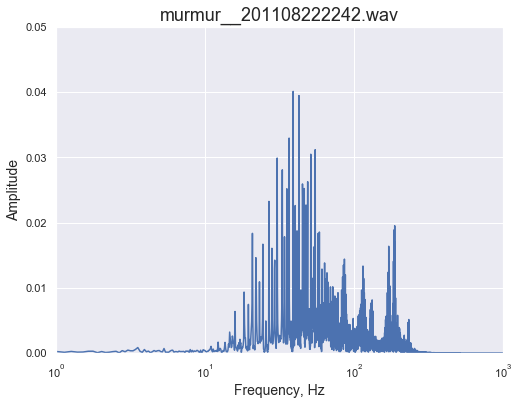

In [34]:
fft_plot(a_wav[9])

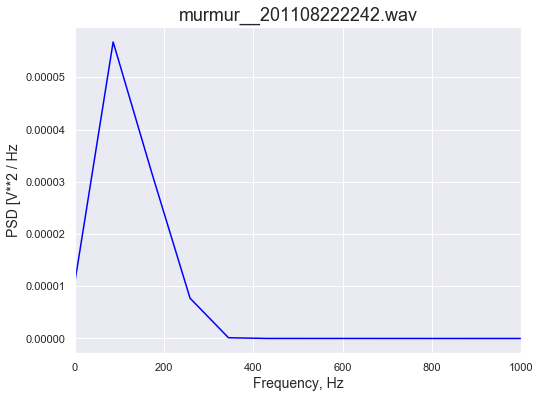

In [35]:
psd_plot(a_wav[9])

### 1.2.4 EDA on Extra Heart Sound (set a)

Extra heart sounds can be identified because there is an additional sound, e.g. a “lub-lub dub” or a “lub dub-dub”. An extra heart sound may not be a sign of disease.  However, in some situations it is an important sign of disease, which if detected early could help a person.  The extra heart sound is important to be able to detect as it cannot be detected by ultrasound very well. Below, note the temporal description of the extra heart sounds:

…lub.lub……….dub………..………. lub. lub……….dub…………….lub.lub……..…….dub…….

or

…lub………. dub.dub………………….lub.……….dub.dub………………….lub……..…….dub. dub……

Duration of audio wav file: 7.88 sec


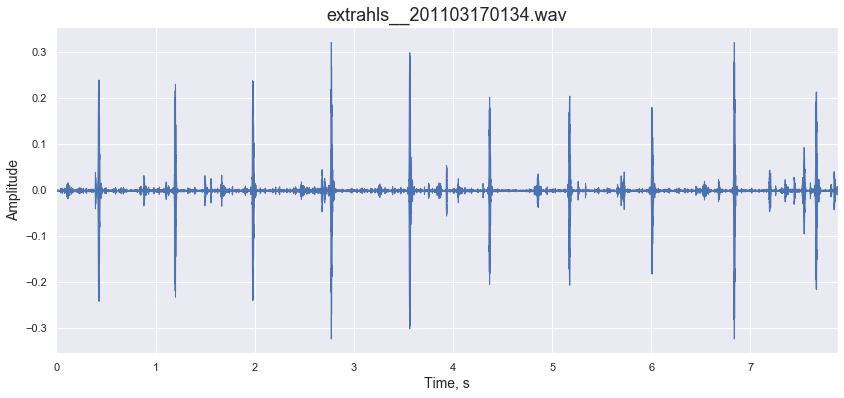

In [36]:
### Plot audio from a_wav[5]
data, sfreq, dur = time_plot(a_wav[5])

print(f'Duration of audio wav file: {round(dur, 2)} sec')

In [37]:
ipd.Audio(a_wav[5])

Visual inpection on the audio in both frequency domain and time domain:
- the heart beat sound is at higher frequency, around 200-300Hz.
- extra S2 (dub) heard after S2, which in above time series plot, there are >1 small peak after the big peak.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.
  


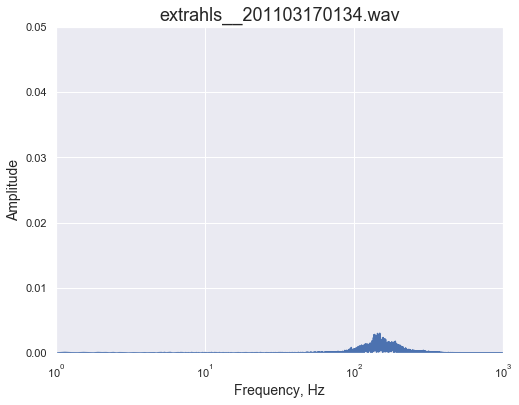

In [38]:
fft_plot(a_wav[5])

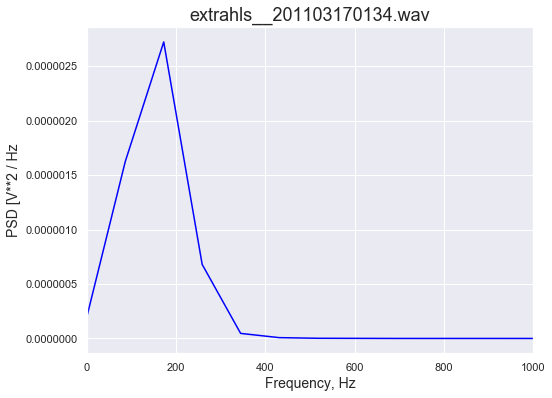

In [39]:
psd_plot(a_wav[5])

### 1.2.5 EDA on Artifact Category (set a)

In the Artifact category there are a wide range of different sounds, including feedback squeals and echoes, speech, music and noise. There are usually no discernable heart sounds, and thus little or no temporal periodicity at frequencies below 195 Hz. This category is the most different from the others. It is important to be able to distinguish this category from the other three categories, so that someone gathering the data can be instructed to try again.

Duration of audio wav file: 9.0 sec


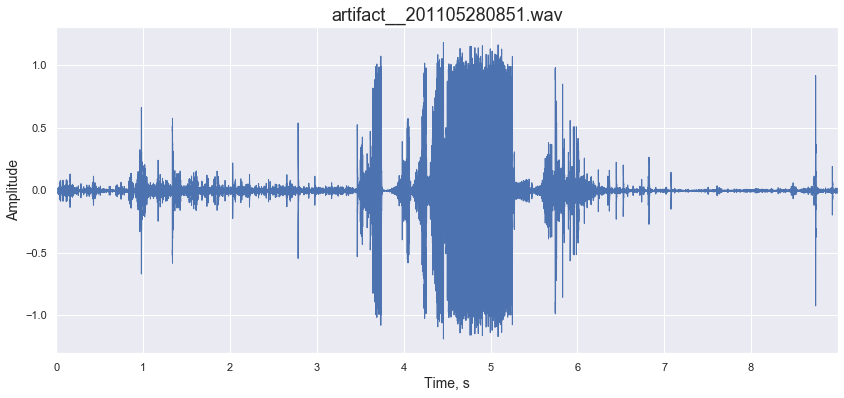

In [40]:
### Plot audio from a_wav[7]
data, sfreq, dur = time_plot(a_wav[7])

print(f'Duration of audio wav file: {round(dur, 2)} sec')

In [41]:
ipd.Audio(a_wav[7])

Visual inpection on the audio in both frequency domain and time domain:
- there are barely heart sound heard, mainly with various type of noise. No periodic signal observed in time domain and the frequency spread from low frequency up to beyond 1kHz.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.
  


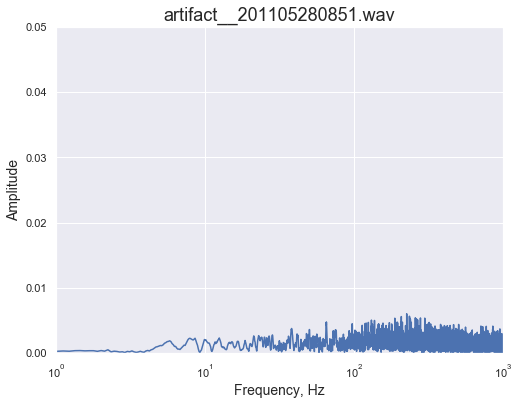

In [42]:
fft_plot(a_wav[7])

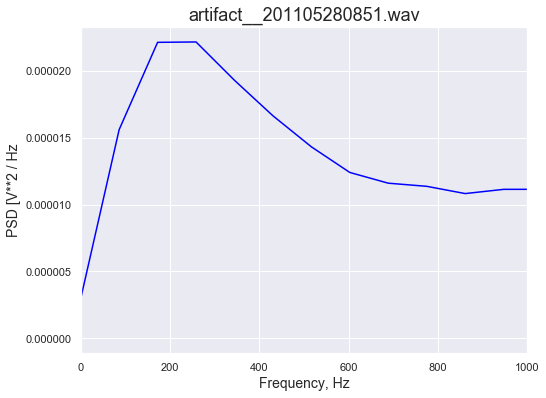

In [43]:
psd_plot(a_wav[7])

### 1.2.6 EDA on Extrasystole (set b)

Extrasystole sounds may appear occasionally and can be identified because there is a heart sound that is out of rhythm involving extra or skipped heartbeats, e.g. a “lub-lub dub” or a “lub dub-dub”. (This is not the same as an extra heart sound as the event is not regularly occuring.) An extrasystole may not be a sign of disease. It can happen normally in an adult and can be very common in children. However, in some situations extrasystoles can be caused by heart diseases. If these diseases are detected earlier, then treatment is likely to be more effective. Below, note the temporal description of the extra heart sounds:

…........lub……….dub………..………. lub. ………..……….dub…………….lub.lub……..…….dub…….

or

…lub………. dub......………………….lub.…………………dub.dub………………….lub……..…….dub.……

Duration of audio wav file: 5.64 sec


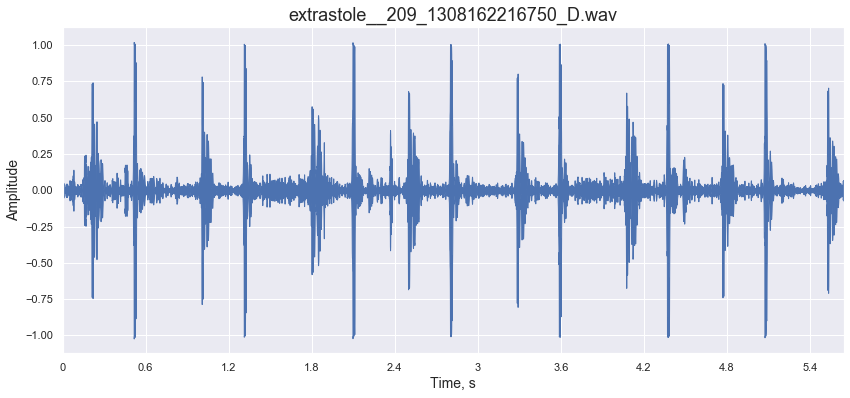

In [44]:
### Plot audio from b_wav[23]
data, sfreq, dur = time_plot(b_wav[23])

print(f'Duration of audio wav file: {round(dur, 2)} sec')

In [45]:
ipd.Audio(b_wav[23])

Visual inpection on the audio in both frequency domain and time domain:
- the heart beat sound is at higher frequency, around 80Hz.
- it is not easy to hear the extrasystole sounds, it seems appeared at around 2.4s in the tim-series plot

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.
  


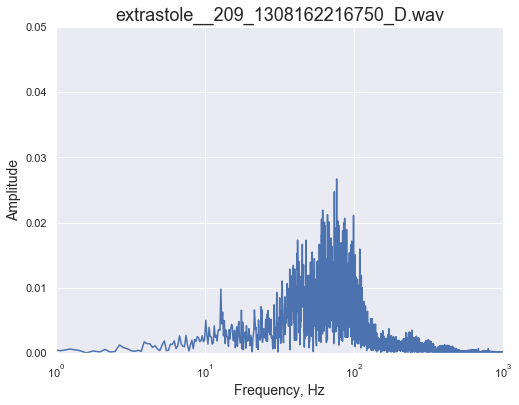

In [46]:
fft_plot(b_wav[23])

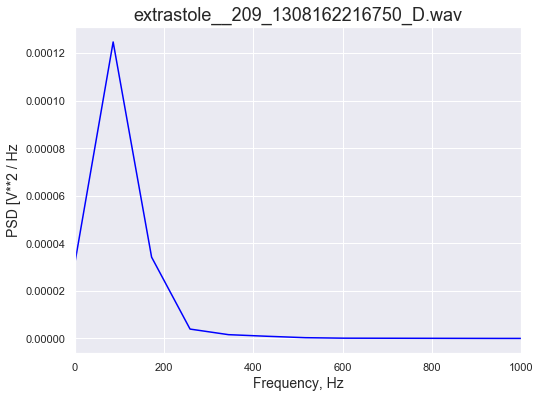

In [47]:
psd_plot(b_wav[23])

# 2.0 Pre-processing

The original recorded wav files in both set A and set B have certain level of contanmination with background noise. This is observed especially in the frequency domain spectrum in EDA. Thus, we'll need to clean the wav file to only contain as much of the wanted audio signal (i.e. the S1 & S2 heartbeat sound) before modeling.


## 2.1 Denoise audio signal

From EDA, we can hear that the recorded audio is masked with background noise. This could make it hard to detect the S1 and S2 signal.

**Denoise** by removing (high-frequency) noise using **Discrete Wavelet Transform** (DWT)

DWT is implemented as a filter-bank which can deconstruct a signal into its frequency sub-bands. It can desconstruct the noisy signal into the approximation (low pass) and detail (high pass) coefficients. 
To filter out the unwanted high frequency noise, setting the detail coefficients to zero to filter out that part of the high frequency spectrum. This can be done by using `pywt.threshold()`, which removes coefficient values higher than a given threshold. Then, reconstruct the signal again from the remaining coefficients.


source:

[Guide using wavelet transformation in machine learning](http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/)

[pywavelets](https://pywavelets.readthedocs.io/en/latest/)

In [48]:
### The PyWavelets library contains 14 mother Wavelets (families of Wavelets):
### A wavelet must have 1) finite energy and 2) zero mean.
### For heartbeat sound, I will use the 'Daubechies' Wavelets to decompose as it has 
### characteristics closes to the heartbeat sound

print(pywt.families(short=False))


['Haar', 'Daubechies', 'Symlets', 'Coiflets', 'Biorthogonal', 'Reverse biorthogonal', 'Discrete Meyer (FIR Approximation)', 'Gaussian', 'Mexican hat wavelet', 'Morlet wavelet', 'Complex Gaussian wavelets', 'Shannon wavelets', 'Frequency B-Spline wavelets', 'Complex Morlet wavelets']


Within each wavelet family there can be a lot of different wavelet subcategories belonging to that family. You can distinguish the different subcategories of wavelets by the number of coefficients (the number of vanishing moments) and the level of decomposition.

This is illustrated below in for **‘Daubechies’** (short-form, db), the wavelet family that I selected to decompose the heartbeat audio.

In [49]:
### list of wavelet sub-categories
#pywt.wavelist()

['db6', 'db7', 'db8', 'db9', 'db10']


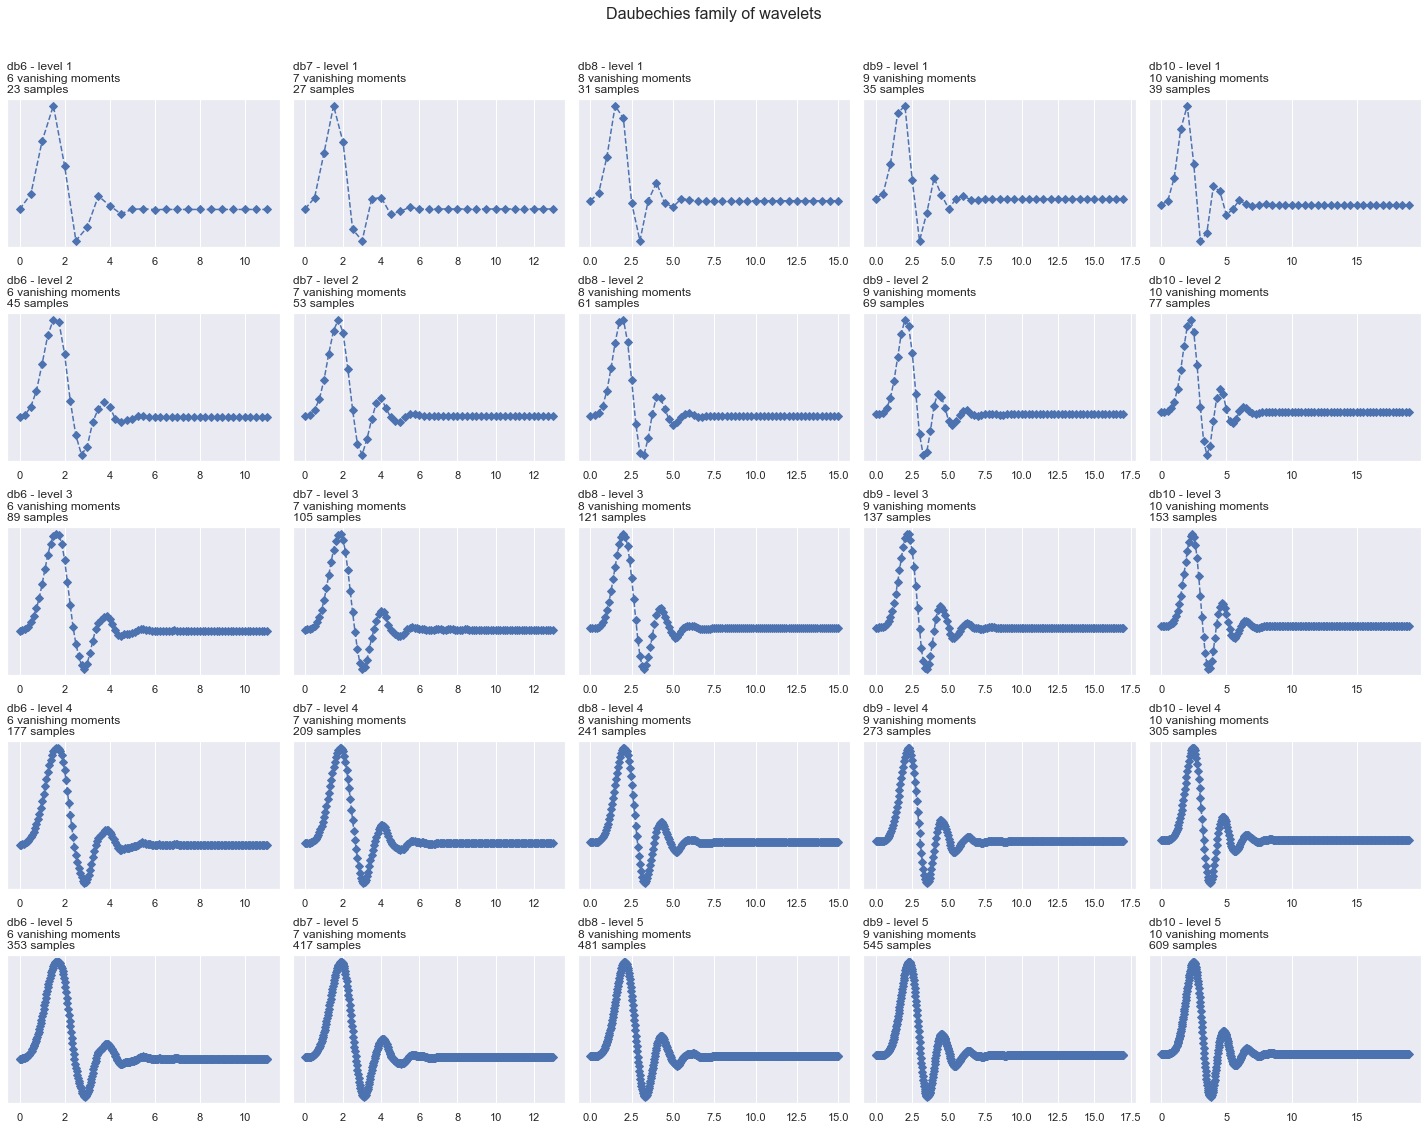

In [50]:
### plot the ‘Daubechies’ wavelet family
db_wavelets = pywt.wavelist('db')[5:10]
print(db_wavelets)

 
fig, axarr = plt.subplots(ncols=5, nrows=5, figsize=(20,16))
fig.suptitle('Daubechies family of wavelets', fontsize=16)
for col_no, waveletname in enumerate(db_wavelets):
    wavelet = pywt.Wavelet(waveletname)
    no_moments = wavelet.vanishing_moments_psi
    family_name = wavelet.family_name
    for row_no, level in enumerate(range(1,6)):
        wavelet_function, scaling_function, x_values = wavelet.wavefun(level = level)
        axarr[row_no, col_no].set_title("{} - level {}\n{} vanishing moments\n{} samples".format(
            waveletname, level, no_moments, len(x_values)), loc='left')
        axarr[row_no, col_no].plot(x_values, wavelet_function, 'bD--')
        axarr[row_no, col_no].set_yticks([])
        axarr[row_no, col_no].set_yticklabels([])
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

### Deconstructing a signal using DWT

#### Search for wavelet subcategories and level, based on one wav file (plot shown in the subsequent cell)

- Tweak the wavelet list (from db1 and up, which increases the vanishing moment).
- Tweak the level to reduce the noise
- Tweak the threshold to include the small peak as much as possible

In [11]:
### Define function to remove the high frequency using DWT

def denoise_signal(x, wavelet='db6', level = 8):
    
    # Decompose to get the wavelet coefficients
    coeff = pywt.wavedec(x, wavelet=wavelet, mode="per", level= level)
     
    # Calculte the univeral threshold
    # the 0.3 value is tweak until I can reconstruct all the peak (without lefting out the small peak)
    thresh = 0.3 * np.nanmax(x)       
    coeff[1:] = ( pywt.threshold( i, value=thresh, mode='hard' ) for i in coeff[1:] )
    
    # Reconstruct the signal using the thresholded coefficients
    return pywt.waverec( coeff, wavelet = wavelet, mode='per' )
    

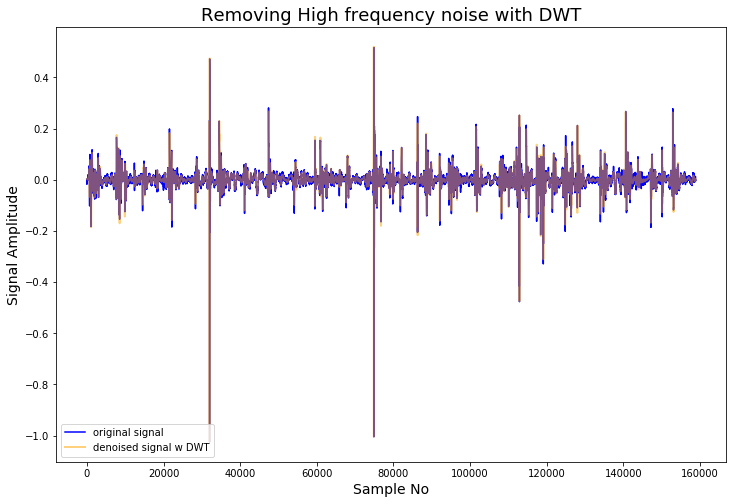

In [12]:
### denoise the signal, tweak the wavlet subcategories (this wave is use to tweak the wavelet subcategories and threshold)

### try the signal from set_b, noisy normal
audio, sr = lr.load(b_wav[3])

### this is the denoised signal
rec = denoise_signal(audio)

### plot original and denoised signal in TIME DOMAIN
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(audio, color = 'b', label = 'original signal');

ax.plot(rec, 'orange', alpha = 0.5, label = 'denoised signal w DWT', linewidth =2);
ax.legend(loc = 3)

ax.set_title('Removing High frequency noise with DWT', fontsize = 18)
ax.set_ylabel('Signal Amplitude', fontsize = 14)
ax.set_xlabel('Sample No', fontsize = 14)
plt.show()


### Listen to the original and denoised signal

- It helps to filter out some high frequency noise only (perceivable at 5sec and onwards), but not the entire background noise

In [13]:
### original wav
ipd.Audio(b_wav[3])

In [14]:
### denoised wav
ipd.Audio(rec, rate=sr)

### Calculate the Signal to Noise (SNR)
- Apart from visualization the waveform in time domain and listening to the audio signal, I would like to quantify the amount of noise reduction by using SNR.

In [16]:
### Define function to calculate the signal to noise ratio (SNR)
### Check how well the denoise

def snr(audio, thresh):
    thresh = thresh * np.nanmax(audio)
    
    ### extract the signal exceed the threshold
    signal_sq = [i**2 for i in audio if i >= thresh]
    signal_rms =  np.sqrt(sum(signal_sq) / len(signal_sq))
    
    ### calculate the noise (i.e. data not included in signal above)
    noise_sq = [i**2 for i in audio if i < thresh]
    noise_rms = np.sqrt(sum(noise_sq) / len(noise_sq))
    #noise_rms = signal.std(axis =0, ddof =0)
    
    return 20*np.log10(signal_rms/noise_rms)


#### Calculate SNR on the noisy normal heartbeat sound from set b

- `b_wav[3]` is selected to find the suitable subcategories of Daubechiese (short-form, 'db) wavelet to decompose and denoise the heartbreat audio, as it has high unwanted background noise.
- From the time domain plot, it suppresses some of the noises, however, the calculated SNR only improves by around 0.5dB. Thus, there are still substantial amount of background noise did not suppress.
- Proceed to check the denoise performance on other recorded heartbeat audio (10 each from set a and set b)

In [17]:
### SNR
print(f'original SNR: {snr(audio, 0.5)}')
print(f'Denoised SNR: {snr(rec, 0.5)}')

original SNR: 20.56116216049599
Denoised SNR: 21.000625821416264


In [73]:
### Define plot function to plot the frequency spectrum of the de-noised signal

def simfft_plot(signal, sfreq, label):
    n = len(signal)
    
    #check if the len of audio data is odd number
    if n%2 !=0:
        n = n+1   # if size of audio data is in odd number, add one to it before proceed
    
    t = 1/sfreq
    yf = scipy.fft(signal)
    xf = np.linspace(0.0, 1.0/(2.0*t), n//2)
    plt.plot(xf, 2.0/n * np.abs(yf[:n//2]), label = label)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.
  # This is added back by InteractiveShellApp.init_path()


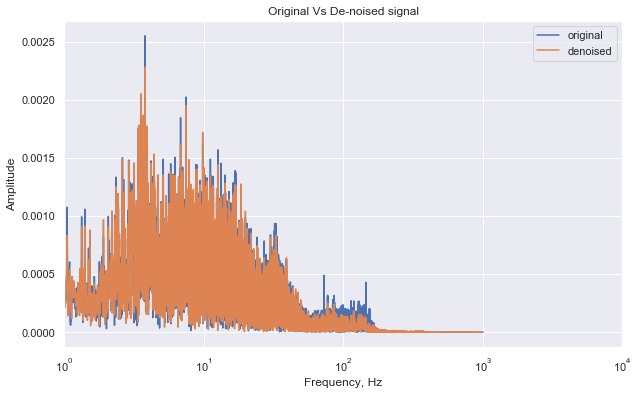

In [75]:
### plot the de-noised signal in FREQUENCY DOMAIN
### Denoise remove the high frequency signal only

plt.subplots(figsize=(10,6))
simfft_plot(audio, 2000, 'original');
simfft_plot(rec, 2000, 'denoised');
plt.xscale('log')
plt.xlim(1, 10000)
plt.legend(loc = 1);
plt.xlabel('Frequency, Hz')
plt.ylabel('Amplitude')
plt.title('Original Vs De-noised signal');


### Denoised 10 audio signal from each folder and plot the signal in time domain

- the selected wavelet and threshold setting is able to denoise those noisy audio with high frequency content. 
- as expected, it cannot remove the background noise with lower frequency.
- SNR is calculated, and it removes the noise from 0dB up to around 2.3dB, depending the type of noise exist in the audio signal.

In [18]:
### load first 10 audio wav in set_a into array using librosa, and store in y_a
y_a = []

for i in range(10):
    y, sr = lr.load(a_wav[i], res_type = 'kaiser_fast')   # use kaiser_fast technique for faster extraction
    y_a.append(y)
    
len(y_a)

10

In [19]:
### load first 10 audio wav in set_b into array using librosa, and store in y_b
y_b = []

for i in range(10):
    y, sr = lr.load(b_wav[i], sr = None, res_type = 'kaiser_fast')  # load with its original sampling rate (i.e. 4kHz)
    y_b.append(y)
    
len(y_b)

10

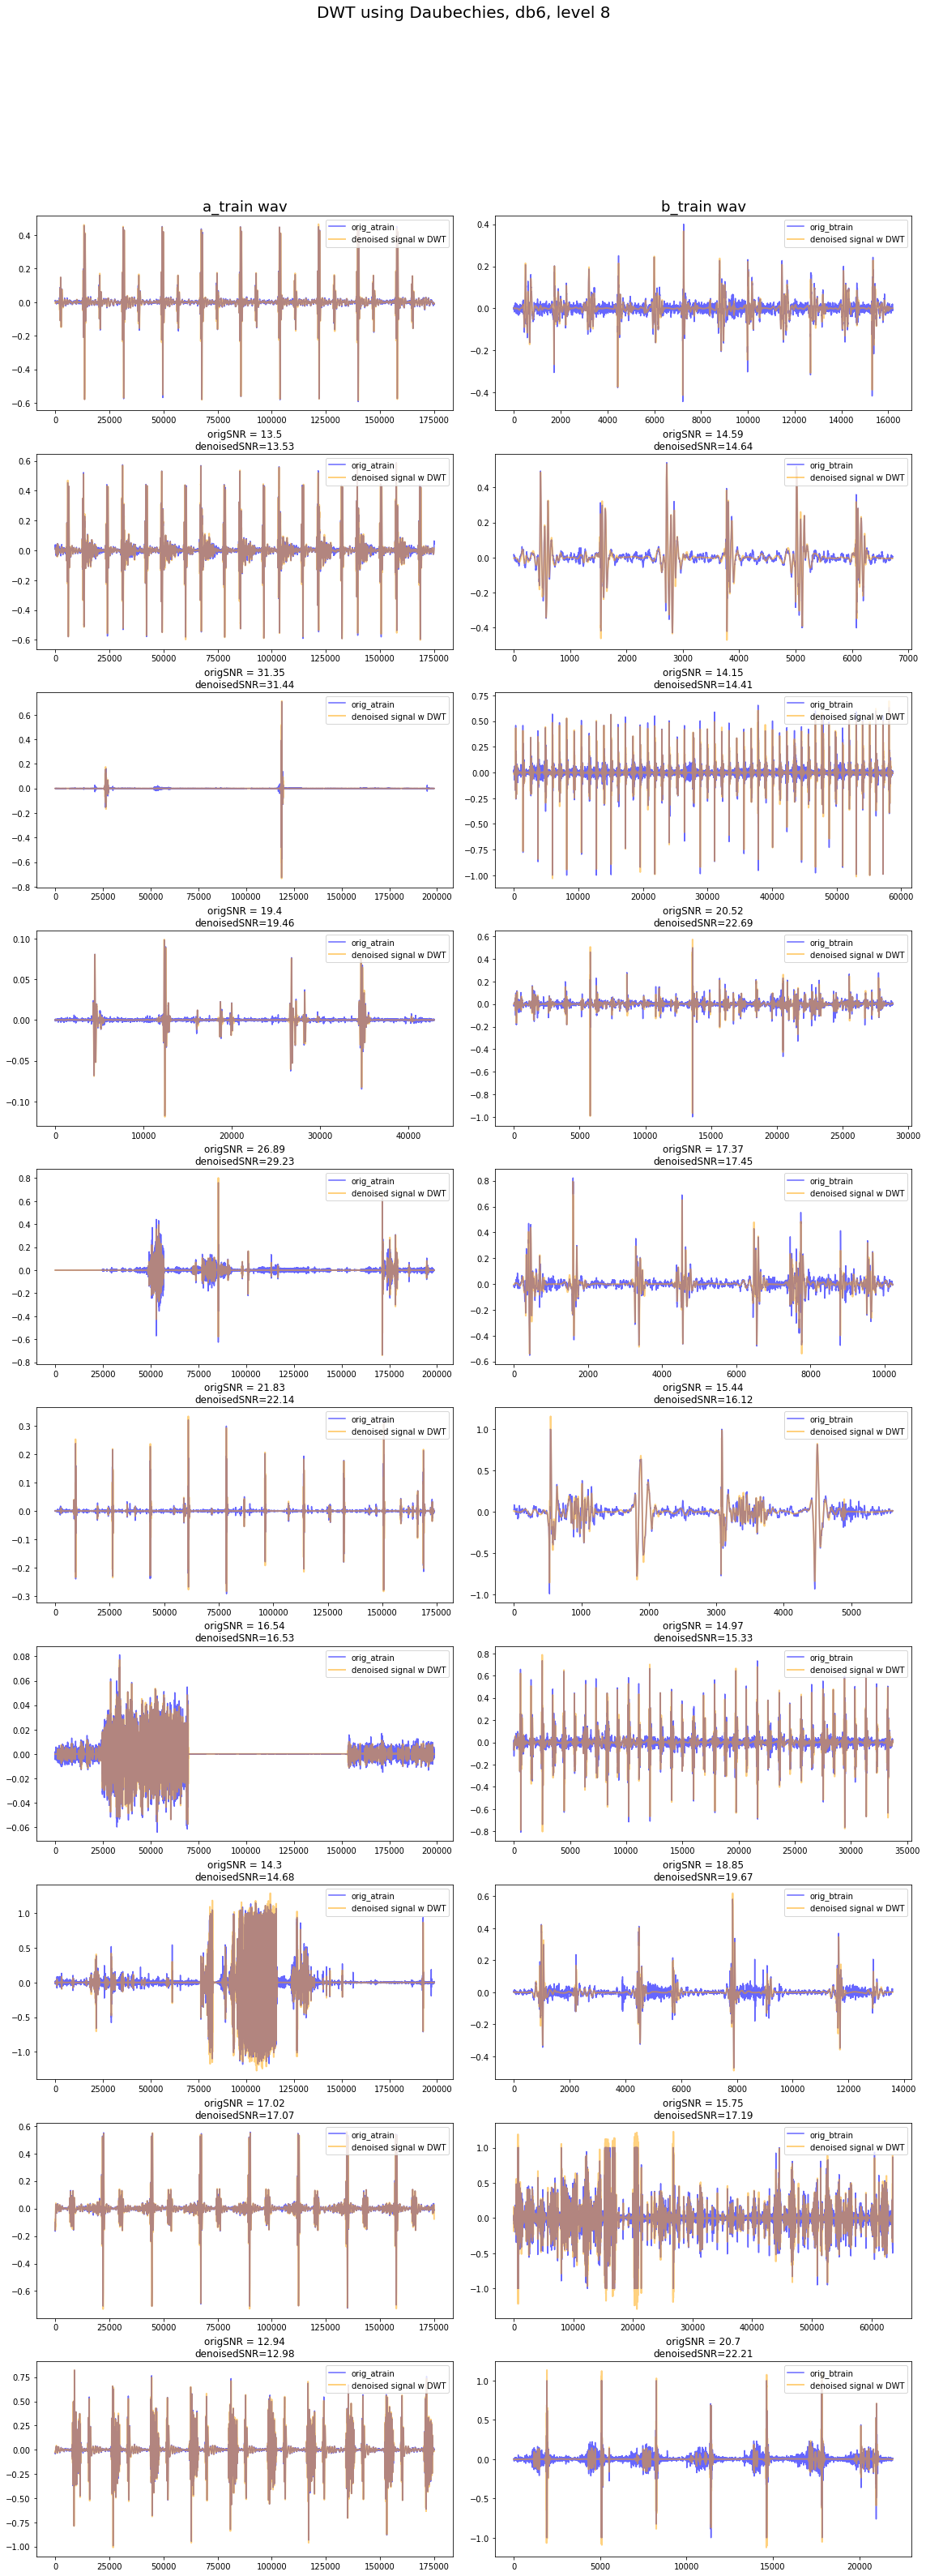

In [20]:
### Plot the denoised audio wav 
fig, ax = plt.subplots (ncols = 2, nrows = 10, figsize = (16, 45))
fig.suptitle('DWT using Daubechies, db6, level 8', fontsize = 20)
snr_orig, snr_denoise = [], []
denoise_a, denoise_b = [], []

for i in range(10):
    signala = y_a[i]    
    signalb = y_b[i]
    
    ### this is the denoised signal
    rec_a = denoise_signal(signala)
    rec_b = denoise_signal(signalb)
    
    # store the denoised signal
    denoise_a.append(rec_a)
    denoise_b.append(rec_b)
    
    ### calculate SNR
    snr_a = snr(signala, 0.5)
    snr_b = snr(signalb, 0.5)
    snr_rec_a = snr(rec_a, 0.5)
    snr_rec_b = snr(rec_b, 0.5)
    
    # store the calculated SNR
    snr_orig.extend([snr_a,snr_b ])
    snr_denoise.extend([snr_rec_a,snr_rec_b ])
 
    
    ### plot original and denoised signal in TIME DOMAIN
    ax[i,0].plot(signala, color = 'b', alpha = 0.6, label = 'orig_atrain');
    ax[i,0].plot(rec_a, 'orange', alpha=0.5, label='denoised signal w DWT', linewidth = 2);
    ax[i,0].set_title(f"origSNR = {round(snr_a,2)}\ndenoisedSNR={round(snr_rec_a,2)}")
    ax[i,0].legend(loc =1)
    
    ax[i,1].plot(signalb, color = 'b', alpha = 0.6, label = 'orig_btrain');
    ax[i,1].plot(rec_b, 'orange', alpha=0.5, label='denoised signal w DWT', linewidth = 2);
    ax[i,1].set_title(f"origSNR = {round(snr_b,2)}\ndenoisedSNR={round(snr_rec_b,2)}")
    ax[i,1].legend(loc =1)
    

ax[0,0].set_title("a_train wav", fontsize=18);
ax[0,1].set_title("b_train wav", fontsize=18);
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


In [21]:
### SNR of original Vs denoised audio wav (10 each from set a and set b)
snr = pd.DataFrame(list(zip(snr_orig, snr_denoise)), columns = ['Original SNR', 'Denoised SNR'])
snr['SNR delta'] = snr['Denoised SNR'] - snr['Original SNR']
snr

Original SNR  Denoised SNR  SNR delta
0      15.999260     16.056422   0.057162
1      15.150697     15.182865   0.032168
2      13.495488     13.526903   0.031415
3      14.587167     14.641325   0.054158
4      31.353450     31.439885   0.086435
5      14.145678     14.412822   0.267144
6      19.398586     19.461973   0.063387
7      20.521482     22.694066   2.172584
8      26.887411     29.225780   2.338369
9      17.367311     17.449822   0.082511
10     21.827334     22.143703   0.316369
11     15.443084     16.123704   0.680620
12     16.536845     16.531340  -0.005505
13     14.967972     15.329461   0.361489
14     14.304618     14.676040   0.371422
15     18.853778     19.673618   0.819840
16     17.024615     17.071126   0.046511
17     15.749863     17.188033   1.438170
18     12.943065     12.981560   0.038496
19     20.698903     22.214069   1.515166

### This is placeholder to re-visit, to further reduce the noise with HPF

- HPF - high pass filter, with cut-off frequency at 15 Hz, that is removing very low frequency noise (<15Hz)

In [43]:
#from scipy import signal

In [44]:
#sos = signal.butter(10,15,'hp', fs = 4000, output = 'sos')
#hpf = signal.sosfilt(sos, rec)

## 2.2 Feature Selection

Audio data can be represented in time domain and frequency domain. 

![audio](../image/time_freq_domain.jpeg)

There are several audio features can be extracted from the audio data for analysis. The goal is to identify the components of the audio signal signal that are good for identifying the content that can be used classify them according to the label (in this project, heartbeat audio from normal, murmur, & etc).
Features considered in this project listed:
1. Spectrogram
2. MFCC
3. Zero-crossing

### 2.2.1 Spectrogram

So far, we only view the signal in either time domain or frequency domain (as illustrated in above picture), which, if in time domain, there is no information about how the signal change in time, and vice versa. 

A spectrogram is a visual representation of the spectrum of frequencies of signal as it vary with time. It’s a representation of frequencies changing with respect to time for signal.

Below cells plot the spectrogram of the first 6 audio wav from each folder (set a & set b). Different audio wav have different patterns in the spectrogram, which we could train our model to classify the pattern.


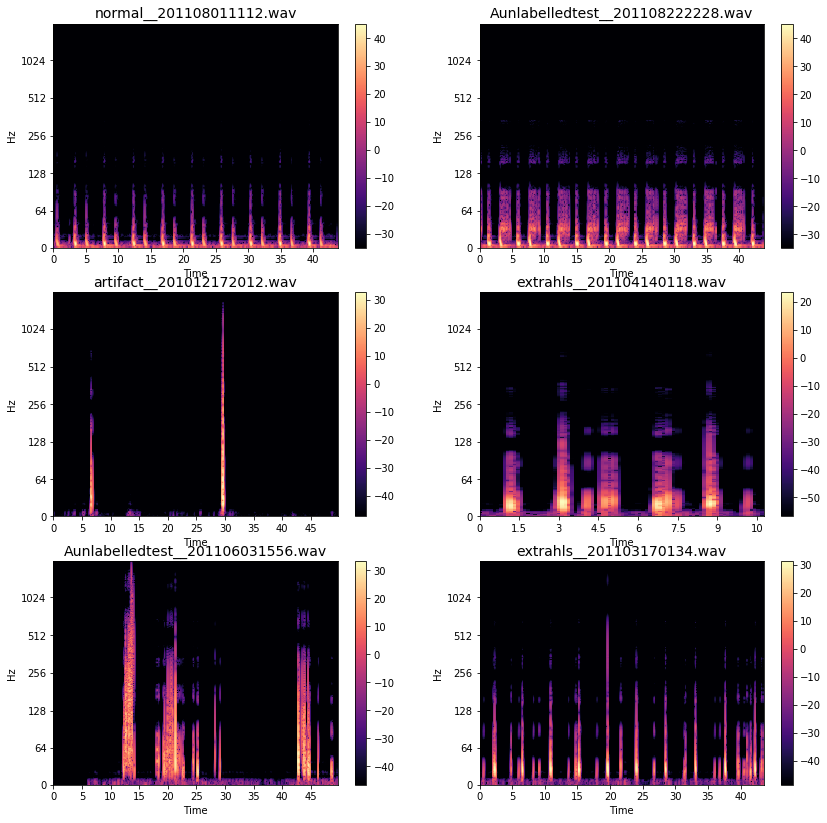

In [22]:
# Spectrogram from set_a folder:

plt.figure(figsize = (14,14))
for i in range(6):
    rec_a = denoise_a[i]    
    
    ### calculate the short-time fourier transform
    X_a = lr.stft(rec_a)
    
    ### convert the signal to log-scale
    Xa_db = lr.amplitude_to_db(abs(X_a))

    ### plot spectrogram
    
    subplot(3,2,i+1)
    lr.display.specshow(Xa_db, sr = 4000, x_axis = 'time', y_axis = 'log')
    plt.title(a_wav[i][29:], fontsize=14)
    plt.colorbar();


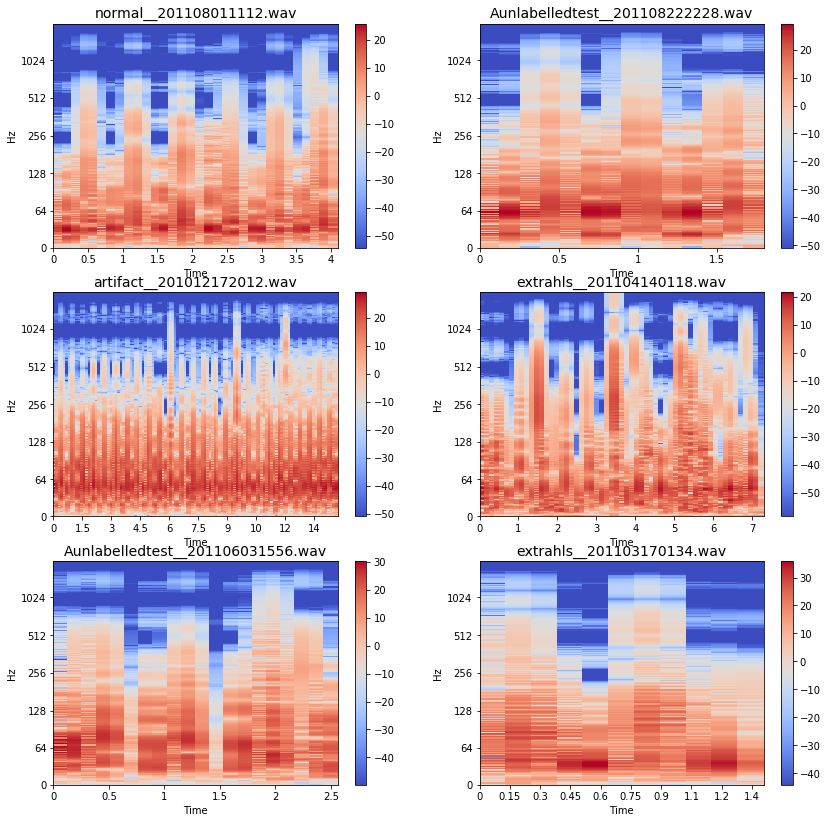

In [23]:
# Spectrogram from set_b folder:

plt.figure(figsize = (14,14))
for i in range(6):
    rec_b = denoise_b[i]    
    
    ### calculate the short-time fourier transform
    X_b = lr.stft(rec_b)
    
    ### convert the signal to log-scale
    Xb_db = lr.amplitude_to_db(abs(X_b))

    ### plot spectrogram
    
    subplot(3,2,i+1)
    lr.display.specshow(Xb_db, sr = 4000, x_axis = 'time', y_axis = 'log')
    plt.title(a_wav[i][29:], fontsize=14)
    plt.colorbar();


### 2.2.2 MFCC

Apart from the spectrogram, a more popular techniques to extract features from audio signals is computing the MFCC (**Mel Frequency Cepstral Coefficients**) from the raw audio signal.

MFCC mimics the logarithmic perception of loudness and pitch of human auditory system and tries to eliminate speaker dependent characteristics by excluding the fundamental frequency and their harmonics. 

Process of extracting MFCC is shown in below block diagram:
![mfcc](../image/MFCC.png)


**Generating MFCC using Librosa**
The library librosa has a function to calculate MFCC. Cell below shows the step to compute the MFCC from librosa.

references: 
[librosa.feature.mfcc](https://librosa.github.io/librosa/generated/librosa.feature.mfcc.html)
[mfcc](https://medium.com/prathena/the-dummys-guide-to-mfcc-aceab2450fd)
[mfcc tutorial](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/)


#### Define function to normalize the MFCC
This is to normalizes the audio time series to have mean around `0` and standard deviation of `1`

In [24]:
def feature_normalize(data):
    mu = np.mean(data, axis = 0)
    sigma = np.std(data, axis = 0)
    return (data - mu)/sigma

#### Visualize MFCC feature

The following cell will plot the MFCC feature of the first 6 audio wav from set_a and set_b folder respectively.

The X-axis is the time (s), and the y-axis is the 20 bands (or 20 mels).
Similarly, there are patterns on each audio wav, which, we can train our model to classify the heartbeat audio based on the patterns.


Mel-Frequency Cepstral Coefficients (MFCCs) from set_a


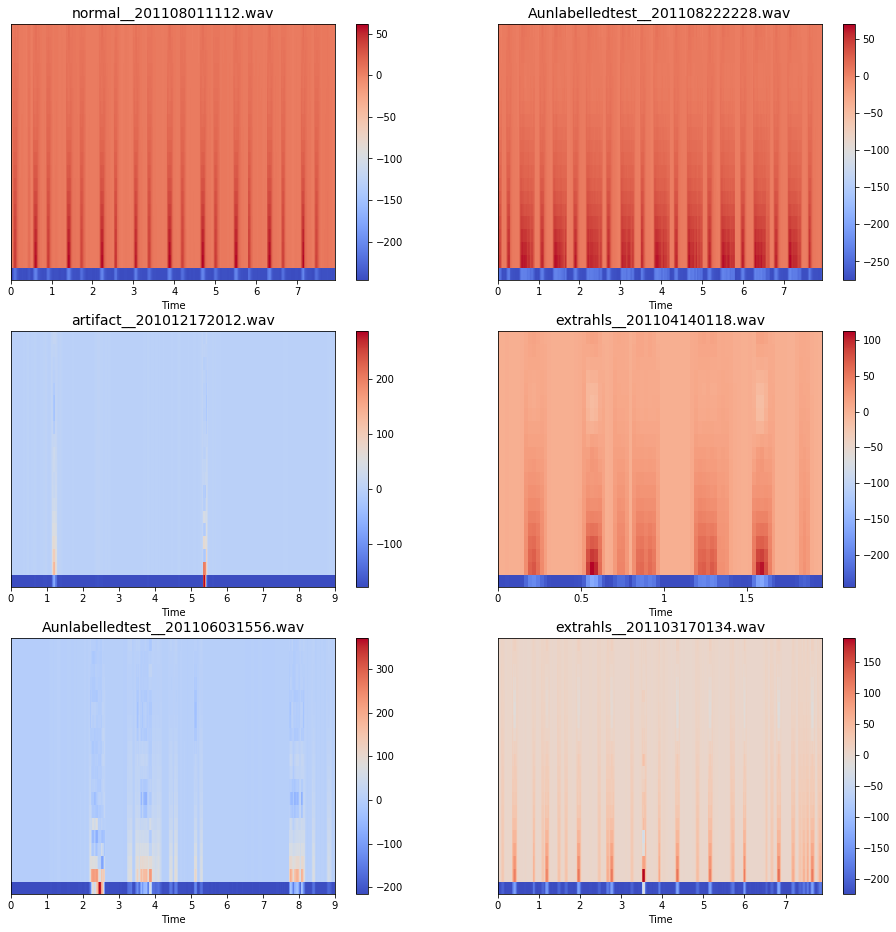

In [25]:
# Visualize MFCC feature of audio signal from set_a folder:

print("Mel-Frequency Cepstral Coefficients (MFCCs) from set_a")

plt.figure(figsize = (16,16))
for i in range(6):
    
    # normalize the audio signal
    denoise_sc = feature_normalize(denoise_a[i])
   
    # get the mfcc feature
    mfccs = lr.feature.mfcc(y = denoise_sc, sr = 4000, n_mfcc = 20)
    
    ### plot mfcc
    subplot(3,2,i+1)
    lr.display.specshow(mfccs, x_axis = 'time')
    plt.title(a_wav[i][29:], fontsize=14)
    plt.colorbar();

Mel-Frequency Cepstral Coefficients (MFCCs) from set_b


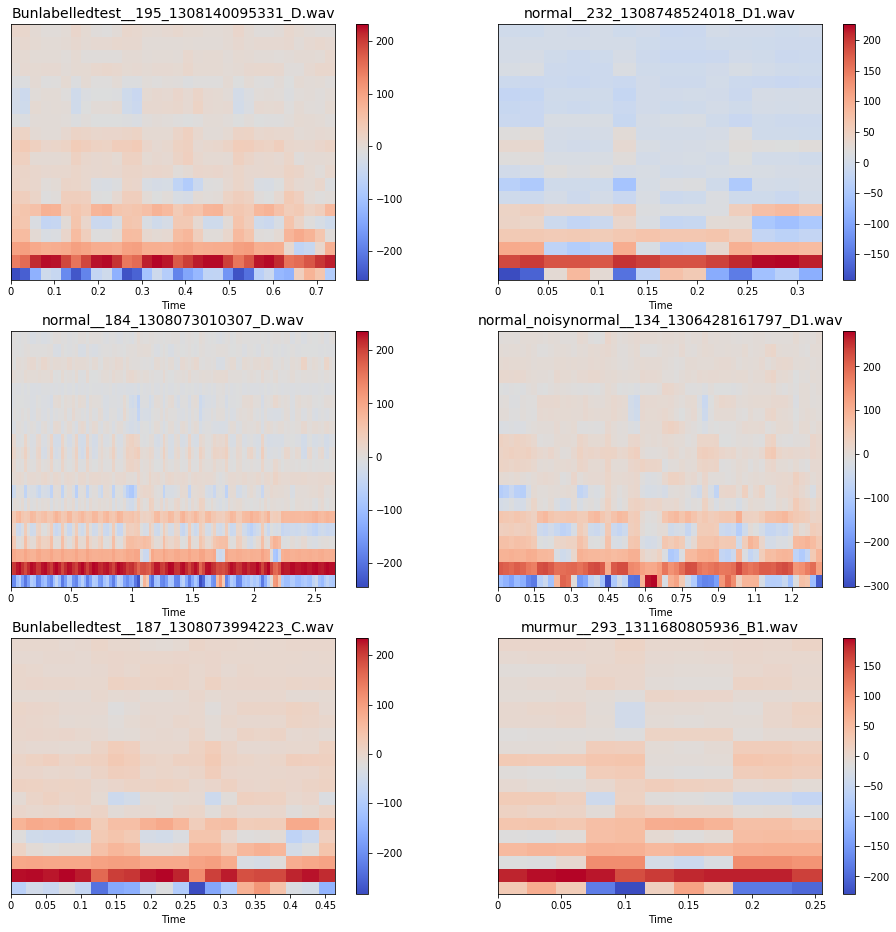

In [26]:
# Visualize MFCC feature of audio signal from set_b folder:

print("Mel-Frequency Cepstral Coefficients (MFCCs) from set_b")

plt.figure(figsize = (16,16))
for i in range(6):
    
    # normalize the audio signal
    denoise_sc = feature_normalize(denoise_b[i])
   
    # get the mfcc feature
    mfccs = lr.feature.mfcc(y = denoise_sc, sr = 4000, n_mfcc = 20)
    
    ### plot mfcc
    subplot(3,2,i+1)
    lr.display.specshow(mfccs, x_axis = 'time')
    plt.title(b_wav[i][29:], fontsize=14)
    plt.colorbar();

## 2.3 Preparing features matrix and y label

### 2.3.1 Compile dataset from set_a & set_b

In [65]:
dataset_a, aunlabel = [], []

for file in (a_wav):
    label = os.path.basename(file).split("__")[0] # normal__20xxx.wav, label is the first item after split
    filename = os.path.basename(file).split("__")[1]
    filepath = file
    dur = lr.get_duration(filename = file)
    # drop unlabeled wav
    if label not in ["Aunlabelledtest", "Bunlabelledtest"]:
        dataset_a.append({'filename': filename,
                         'label': label,
                         'wav_duration': dur,
                         'filepath': filepath,
                         'folder': 'a'})
        
        # compile unlabeled wav for unlabeled prediction
    else:
        aunlabel.append({'filename': filename,
                         'label': label,
                         'wav_duration': dur,
                         'filepath': filepath,
                         'folder': 'a'})

In [53]:
dataset_b, bunlabel = [], []

for file in (b_wav):
    label = os.path.basename(file).split("__")[0] 
    filename = os.path.basename(file).split("__")[1] 
    filepath = file
    dur = lr.get_duration(filename = file)
    # drop unlabeled wav
    if label not in ["Aunlabelledtest", "Bunlabelledtest"]:
        dataset_b.append({'filename': filename,
                         'label': label,
                         'wav_duration': dur,
                         'filepath': filepath,
                         'folder': 'b'})
    else:
        bunlabel.append({'filename': filename,
                         'label': label,
                         'wav_duration': dur,
                         'filepath': filepath,
                         'folder': 'b'})

In [67]:
### convert dataset_a & dataset_b into dataframe
df_a = pd.DataFrame(dataset_a)
df_b = pd.DataFrame(dataset_b)
df_aunlabel = pd.DataFrame(aunlabel)
df_bunlabel = pd.DataFrame(bunlabel)
print(f'df_a : {df_a.shape}')
print(f'df_b : {df_b.shape}')
print(f'df_aunlabel : {df_aunlabel.shape}')
print(f'df_bunlabel : {df_bunlabel.shape}')

df_a : (124, 5)
df_b : (461, 5)
df_aunlabel : (52, 5)
df_bunlabel : (195, 5)


### Combine dataset from folder set_a and set_b

- the heartbeat audio recording duration varies from as short as 0.8 sec up to 27.9 sec, with mean at 6.8sec.
- for labeled audio wav, there are total of 58 (out of 585), which is ~ 10% with recording < 2 sec. For unlabeled audio wav, there are 21.
- Droping audio wav with duration <2 sec, though loss about 10% of data, the overall percentage per group (per label) still retain roughly the same. Thus, will proceed the first modeling by droping short wav (duration <2sec) and zero-padding those audio wav with duration between 2-4 sec.

In [86]:
### combine dataset_a & dataset_b
df_ab = pd.concat([df_a, df_b], ignore_index= True)
df_unlabel = pd.concat([df_aunlabel, df_bunlabel], ignore_index = True)
print(f" df_ab : {df_ab.shape}")
print(f" df_unlabel : {df_unlabel.shape}")
df_ab.describe()

 df_ab : (585, 5)
 df_unlabel : (247, 5)


wav_duration
count    585.000000
mean       6.804404
std        4.091224
min        0.763250
25%        3.280250
50%        6.536750
75%        9.000000
max       27.867000

In [87]:
### unlabel wav duration distribution
df_unlabel.describe()

wav_duration
count    247.000000
mean       7.014634
std        4.546840
min        1.027500
25%        3.208000
50%        6.434750
75%        9.000000
max       24.448750

In [89]:
### group of audio wav < 1sec
print(f"shape combined datasets: {df_ab.shape}")
print(f"shape wav dur < 1sec: {df_ab[df_ab['wav_duration']<1].shape}")
      
df_ab[df_ab['wav_duration']<1].groupby('label').count()

shape combined datasets: (585, 5)
shape wav dur < 1sec: (4, 5)


filename  wav_duration  filepath  folder
label                                             
extrahls         1             1         1       1
murmur           2             2         2       2
normal           1             1         1       1

In [84]:
### unlabel audio wav with wav duration < 2sec
df_unlabel[df_unlabel['wav_duration']<2].groupby('label').count()

filename  wav_duration  filepath  folder
label                                                    
Aunlabelledtest         1             1         1       1
Bunlabelledtest        20            20        20      20

In [72]:
### percentage of audio wav dur <2sec per group
df_ab[df_ab['wav_duration']<2].groupby('label').count()/df_ab.groupby('label').count()*100

filename  wav_duration   filepath     folder
label                                                            
artifact                  NaN           NaN        NaN        NaN
extrahls            15.789474     15.789474  15.789474  15.789474
extrastole           2.173913      2.173913   2.173913   2.173913
murmur               3.000000      3.000000   3.000000   3.000000
murmur_noisymurmur   3.448276      3.448276   3.448276   3.448276
normal              19.480519     19.480519  19.480519  19.480519
normal_noisynormal   4.166667      4.166667   4.166667   4.166667

In [73]:
### Percentage of audio wav per group (original combined dataset_ab)
df_ab.groupby('label').count()/585*100

filename  wav_duration   filepath     folder
label                                                            
artifact             6.837607      6.837607   6.837607   6.837607
extrahls             3.247863      3.247863   3.247863   3.247863
extrastole           7.863248      7.863248   7.863248   7.863248
murmur              17.094017     17.094017  17.094017  17.094017
murmur_noisymurmur   4.957265      4.957265   4.957265   4.957265
normal              39.487179     39.487179  39.487179  39.487179
normal_noisynormal  20.512821     20.512821  20.512821  20.512821

In [74]:
### Percentage of audio wav per group after droping short audio wav (<2 sec) 
df_ab[df_ab['wav_duration']>2].groupby('label').count()/(585-58)*100

filename  wav_duration   filepath     folder
label                                                            
artifact             7.590133      7.590133   7.590133   7.590133
extrahls             3.036053      3.036053   3.036053   3.036053
extrastole           8.538899      8.538899   8.538899   8.538899
murmur              18.406072     18.406072  18.406072  18.406072
murmur_noisymurmur   5.313093      5.313093   5.313093   5.313093
normal              35.294118     35.294118  35.294118  35.294118
normal_noisynormal  21.821632     21.821632  21.821632  21.821632

In [90]:
### drop audio wav with duration < 1sec
df_ab = df_ab[df_ab['wav_duration']>1]

### merge noisy murmur too murmur, and merge noisy normal to normalb
df_ab['label'].replace({'murmur_noisymurmur':'murmur', 'normal_noisynormal':'normal'}, inplace = True)

### 2.3.2 Extract feature from audio wav

- Load and compile the audio with signal duration >2 sec.
- Standardize the length of audio to be 4 sec.
- zero padding on those < 2 sec audio wav.
- post trancate on those > 4 sec audio wav.


In [91]:
%%time
### padding for those audio wav < 4 sec
sfreq = 22050

data_ab = []

for file in df_ab.filepath:
    y, sr = lr.load(file, sr = sfreq, res_type = 'kaiser_fast')
    data_ab.append(y)

### post zero pad on audio wav < 4sec, take the 1st 4 sec on audio >4sec (truncate the remaining)

data_ab = pad_sequences(data_ab, maxlen = sfreq*4, dtype = 'float', 
                        padding = 'post', truncating= 'post', value = 0.)


CPU times: user 20.8 s, sys: 720 ms, total: 21.6 s
Wall time: 22.7 s


In [100]:
%%time
### repeat the same for unlabel dataset
data_unlabel = []
for file in df_unlabel.filepath:
    y, sr = lr.load(file, sr = sfreq, res_type = 'kaiser_fast')
    data_unlabel.append(y)
    
data_unlabel = pad_sequences(data_unlabel, maxlen = sfreq*4, dtype = 'float',
                            padding = 'post', truncating = 'post', value = 0.)

CPU times: user 9.06 s, sys: 288 ms, total: 9.35 s
Wall time: 9.77 s


#### Function for X feature extraction:

1. Denoise using DWT
2. MFCC feature extraction
3. Normalization of MFCC 

In [93]:
### Function to pre-process and then extract the MFCC feature
def extract_feature(data, sr):
    
    # denoise audio signal
    x_denoise = denoise_signal(data)
    
    # normalize audio signal (mean = 0, std =1)
    #x_denoise_sc = feature_normalize(x_denoise)
    
    # extract mfcc feature
    #mfccs = lr.feature.mfcc(y = x_denoise_sc, sr = 22050, n_mfcc = 40)
    mfccs = lr.feature.mfcc(y = x_denoise, sr = sr, n_mfcc = 40)
    
    # mfccs normalization (mu = 0, std =1)
    mfccs_sc = feature_normalize(mfccs)
    
    return mfccs_sc

### extract feature and save in X

In [102]:
%%time

X, X_unlabel = [], []
for i in range(len(data_ab)):
    X.append(extract_feature(data_ab[i], sfreq))

for j in range(len(data_unlabel)):
    X_unlabel.append(extract_feature(data_unlabel[j], sfreq))


CPU times: user 16.5 s, sys: 1.16 s, total: 17.7 s
Wall time: 8.9 s


In [103]:
### change X to array
X = np.asarray(X)
X_unlabel = np.asarray(X_unlabel)

print(f'X: {X.shape}')
print(f'X_unlabel: {X_unlabel.shape}')

X: (581, 40, 173)
X_unlabel: (247, 40, 173)


### get the  y target, that is the label

In [105]:
### Extract label as y-target and one-hot encode to integer
y = df_ab.label

le = LabelEncoder()
y = le.fit_transform(y)

# to get back the label, use le.inverse_transform(y)

y.shape

(581,)

## 2.3.3 Train test split

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True,
                                                   stratify = y, random_state=True)

In [107]:
print(f" shape X_train: {X_train.shape}")
print(f" shape y_train: {y_train.shape}")
print(f" shape X_test: {X_test.shape}")
print(f" shape y_test: {y_test.shape}")

 shape X_train: (464, 40, 173)
 shape y_train: (464,)
 shape X_test: (117, 40, 173)
 shape y_test: (117,)


## 2.3.4 Compute class weight

This is imbalanced multiclass, thus calculate the class weight to use it for weighting the loss function (during training only).

`'balanced'` => n_samples / (n_classes * np.bincount(y))

In [108]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weights

array([2.9       , 6.62857143, 2.50810811, 0.91881188, 0.33142857])

In [109]:
### the corresponding class according to the above class weight
np.unique(le.inverse_transform(y))

array(['artifact', 'extrahls', 'extrastole', 'murmur', 'normal'],
      dtype=object)

## 2.3.5 Re-shape X and change y to dummies

In [111]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
X_unlabel = X_unlabel.reshape(X_unlabel.shape[0], X_unlabel.shape[1], X_unlabel.shape[2], 1)

### change int categorical to dummies
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(f'shape X_train : {X_train.shape}')
print(f'shape X_test : {X_test.shape}')
print(f'shape X_unlabel : {X_unlabel.shape}')
print(f'shape y_train : {y_train.shape}')
print(f'shape y_test : {y_test.shape}')

shape X_train : (464, 40, 173, 1)
shape X_test : (117, 40, 173, 1)
shape X_unlabel : (247, 40, 173, 1)
shape y_train : (464, 5)
shape y_test : (117, 5)


# 3 Modelling

## 3.1 Convolutional Neural Network (CNN)

In [112]:
### Build model

model = Sequential()

# add 1st convolutional layer
model.add(Conv2D(filters = 16, kernel_size = 2, activation = 'relu', 
                 input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])))
model.add(MaxPooling2D(pool_size = 2))
# add 2nd convoluational layer
model.add(Conv2D(filters = 32, kernel_size = 2, activation = 'relu'))
model.add(MaxPooling2D(pool_size =2))
model.add(Dropout(0.1))
# add 3rd convoluational layer
model.add(Conv2D(filters = 64, kernel_size = 2, activation = 'relu'))
model.add(MaxPooling2D(pool_size =2))
model.add(Dropout(0.1))
# add 4th convolutional layer
model.add(Conv2D(filters = 128, kernel_size = 2, activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(len(le.classes_), activation = 'softmax'))
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 39, 172, 16)       80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 86, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 85, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 42, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 42, 32)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 41, 64)         8256      
______________________________________

#### Compile model

In [113]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

#### Fit model

In [114]:
history = model.fit(X_train, y_train, validation_data = (X_test, y_test),
                    epochs = 100, batch_size=128, class_weight=class_weights, shuffle = True, verbose = 2)


Train on 464 samples, validate on 117 samples
Epoch 1/100
 - 2s - loss: 1.3893 - accuracy: 0.5668 - val_loss: 1.2469 - val_accuracy: 0.5983
Epoch 2/100
 - 1s - loss: 1.1884 - accuracy: 0.6034 - val_loss: 1.1480 - val_accuracy: 0.5983
Epoch 3/100
 - 1s - loss: 1.1528 - accuracy: 0.6034 - val_loss: 1.1354 - val_accuracy: 0.5983
Epoch 4/100
 - 1s - loss: 1.1189 - accuracy: 0.6034 - val_loss: 1.1461 - val_accuracy: 0.5983
Epoch 5/100
 - 2s - loss: 1.1116 - accuracy: 0.6034 - val_loss: 1.1262 - val_accuracy: 0.5983
Epoch 6/100
 - 1s - loss: 1.0989 - accuracy: 0.6034 - val_loss: 1.1076 - val_accuracy: 0.5983
Epoch 7/100
 - 1s - loss: 1.0921 - accuracy: 0.6034 - val_loss: 1.0987 - val_accuracy: 0.5983
Epoch 8/100
 - 1s - loss: 1.0836 - accuracy: 0.6034 - val_loss: 1.0907 - val_accuracy: 0.6068
Epoch 9/100
 - 1s - loss: 1.0662 - accuracy: 0.6121 - val_loss: 1.0620 - val_accuracy: 0.6154
Epoch 10/100
 - 2s - loss: 1.0572 - accuracy: 0.6142 - val_loss: 1.0417 - val_accuracy: 0.6239
Epoch 11/100

Epoch 85/100
 - 1s - loss: 0.5817 - accuracy: 0.7672 - val_loss: 0.7497 - val_accuracy: 0.7265
Epoch 86/100
 - 1s - loss: 0.5800 - accuracy: 0.7716 - val_loss: 0.7699 - val_accuracy: 0.7607
Epoch 87/100
 - 1s - loss: 0.5597 - accuracy: 0.7866 - val_loss: 0.7487 - val_accuracy: 0.7179
Epoch 88/100
 - 1s - loss: 0.5696 - accuracy: 0.7802 - val_loss: 0.7495 - val_accuracy: 0.7692
Epoch 89/100
 - 2s - loss: 0.5731 - accuracy: 0.7802 - val_loss: 0.7643 - val_accuracy: 0.7179
Epoch 90/100
 - 1s - loss: 0.6017 - accuracy: 0.7694 - val_loss: 0.7758 - val_accuracy: 0.7521
Epoch 91/100
 - 1s - loss: 0.5583 - accuracy: 0.7888 - val_loss: 0.7235 - val_accuracy: 0.7521
Epoch 92/100
 - 1s - loss: 0.5540 - accuracy: 0.7845 - val_loss: 0.7242 - val_accuracy: 0.7692
Epoch 93/100
 - 1s - loss: 0.5416 - accuracy: 0.7974 - val_loss: 0.7453 - val_accuracy: 0.7692
Epoch 94/100
 - 1s - loss: 0.5440 - accuracy: 0.7845 - val_loss: 0.7282 - val_accuracy: 0.7863
Epoch 95/100
 - 1s - loss: 0.5436 - accuracy: 0.79

#### Loss and Accuracy Score

Text(0.5, 1.0, 'Accuracy Curve')

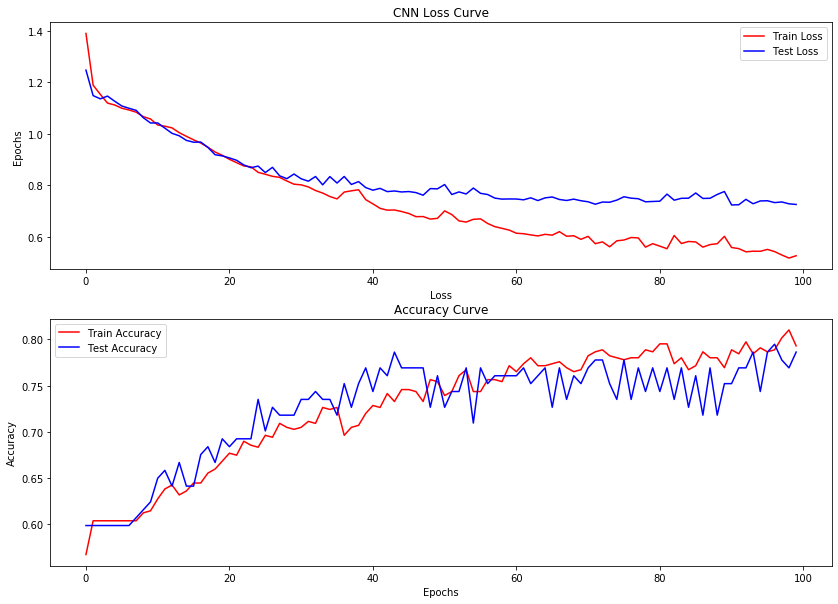

In [115]:
plt.figure(figsize = (14,10))
plt.subplot(211)
plt.plot(history.history['loss'], 'r', label = 'Train Loss')
plt.plot(history.history['val_loss'], 'b', label = 'Test Loss')
plt.legend(loc=1)
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.title('CNN Loss Curve')

plt.subplot(212)
plt.plot(history.history['accuracy'], 'r', label = 'Train Accuracy')
plt.plot(history.history['val_accuracy'], 'b', label = 'Test Accuracy')
plt.legend(loc=2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')

In [118]:
### X_test loss and accuracy score

model_score = model.evaluate(X_test, y_test, verbose =2)
model_labels = model.metrics_names

print(f'cnn {model_labels[0]}: {round(model_score[0], 3)}')
print(f'cnn {model_labels[1]}: {round(model_score[1], 3)}')

cnn loss: 0.725
cnn accuracy: 0.786


#### Model prediction and evaluation on X_test

In [119]:
### Predict the X_test
pred = model.predict_classes(X_test)

### Compile predicted results
y_true, y_pred = [], []
classes = le.classes_

for idx, preds in enumerate(pred):
    y_true.append(classes[np.argmax(y_test[idx])])
    y_pred.append(classes[preds])

In [120]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

    artifact       0.88      0.88      0.88         8
    extrahls       0.00      0.00      0.00         4
  extrastole       0.00      0.00      0.00         9
      murmur       0.85      0.65      0.74        26
      normal       0.76      0.97      0.86        70

    accuracy                           0.79       117
   macro avg       0.50      0.50      0.49       117
weighted avg       0.71      0.79      0.74       117



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [121]:
### View the class with WRONG classificaiton 
cnn_pred_result = list(zip(y_true, y_pred))
cnn_result_df = pd.DataFrame(cnn_pred_result, columns = ['label', 'pred_label'])
cnn_result_df[cnn_result_df['label'] != cnn_result_df['pred_label']]

label pred_label
2    extrastole     normal
9    extrastole     normal
10       murmur     normal
12       normal     murmur
14   extrastole     normal
21       murmur     normal
22   extrastole     normal
25     extrahls     normal
30       murmur     normal
31     extrahls     normal
34   extrastole     normal
35   extrastole     normal
40       murmur     normal
45       murmur     normal
46   extrastole     normal
58     artifact     normal
59       murmur   artifact
63       murmur     normal
81       murmur     normal
84       murmur     normal
85   extrastole     normal
89     extrahls     normal
112      normal     murmur
113    extrahls     murmur
115  extrastole     normal

#### Confusion Matrix

In [122]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    plt.tight_layout()

    plt.show()

In [133]:
confusion_matrix(y_true, y_pred)

array([[ 7,  0,  0,  0,  1],
       [ 0,  0,  0,  1,  3],
       [ 0,  0,  0,  0,  9],
       [ 1,  0,  0, 17,  8],
       [ 0,  0,  0,  2, 68]])

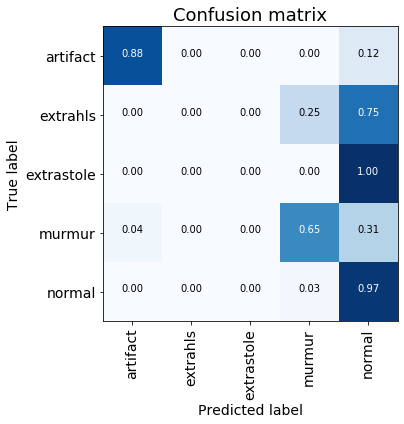

In [131]:
cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix = cnf_matrix.astype(float) / cnf_matrix.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cnf_matrix, classes)

#### Youden’s Index

It is traditionally used to compare diagnostic abilities of two tests, by evaluating the algorithm’s ability to avoid failure. 

In Dataset A, we evaluate the Youden’s Index of the **Artifact category**. 

In Dataset B we calculate the Youden’s Index of problematic heartbeats (**Murmur and Extrasystole** categories combined).

Youden's Index = sensitivity  - (1- specificity)

sensitivity = tp/(tp+fn)
specificity = tn/(fp+tn)